# **Solución de problemas**

**1.** Se importa la librería de **pandas** y con su función `read.csv()` se importa la base de datos "*A1.5 Calificaciones.csv*". Después, para conocer el **tipo de datos** de cada variable, se imprimen los tipos de dato con el comando `.dtypes`.

In [247]:
import pandas as pd
df = pd.read_csv("A1.5 Calificaciones.csv")
print(df.dtypes);

Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


**2.** Para preparar los datos y evitar problemas, se transforman las variables categóricas a **variables booleanas** para que sean útiles para la generación de un modelo de regresión lineal múltiple. En este caso, las variables categóricas son **'Escuela', 'Sexo', 'Internet' y 'HorasDeEstudio'**.

Para la transformación se utilizó la función `get_dummies()` de **pandas**. Para las variables con solo 2 opciones se estableció el parámetro `drop_first = True` para **evitar colinearidad** posterior.

In [248]:
df = pd.get_dummies(df,columns=['Escuela','Sexo','Internet'], drop_first = True)
df = pd.get_dummies(df,columns=['HorasDeEstudio'])
print(df.head(5))

   Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
0    18           0       6   5   6   6       False   False         False   
1    17           0       4   5   5   6       False   False          True   
2    15           3      10   7   8  10       False   False          True   
3    15           0       2  15  14  15       False   False          True   
4    16           0       4   6  10  10       False   False         False   

   HorasDeEstudio_1  HorasDeEstudio_2  HorasDeEstudio_3  HorasDeEstudio_4  
0             False              True             False             False  
1             False              True             False             False  
2             False              True             False             False  
3             False             False              True             False  
4             False              True             False             False  


**3.** Se identifican **valores atípicos** de la variable **'Faltas'** utilizando el **método Tukey con k=3**. Para esto se importa la librería **numpy**. Se calculan ambos **cuartiles 1 y 3**, así como el **rango intercuartíl (Q3 - Q1)**. Posteriormente se calculan los **límites inferior y superior** y se identifican los **outliers** como **todos aquellos cuyo número de faltas salga de este rango**. Se imprimen los outliers encontrados.

In [249]:
import numpy as np
column = 'Faltas'
Q1 = df[column].quantile(0.25)
Q3 = df[column].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
print("Atypical values (outliers):")
print(outliers)
df = df.drop(index = [74, 183, 276])

Q1: 0.0, Q3: 8.0, IQR: 8.0
Lower Bound: -24.0, Upper Bound: 32.0
Atypical values (outliers):
     Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
74     16           0      54  11  12  11       False   False          True   
183    17           0      56   9   9   8       False   False          True   
276    18           0      75  10   9   9       False   False          True   
307    19           1      38   8   9   8       False    True          True   
315    19           1      40  13  11  11       False   False          True   

     HorasDeEstudio_1  HorasDeEstudio_2  HorasDeEstudio_3  HorasDeEstudio_4  
74              False              True             False             False  
183             False              True             False             False  
276             False              True             False             False  
307              True             False             False             False  
315             False             False   

Tomando en cuenta el rango intercuartíl de **-24 a 32** los datos con índices **74, 183 y 276** tienen valores significativamente más altos al límite superior del rango
mientras que los datos con índices **307 y 315** no se encuentran muy por encima del rango. Tomando en cuenta el contexto, los primeros 3 outliers podrían representar **bajas en donde los alumnos dejaron de asistir** ya que considerando una duración promedio de un año escolar de **100 días**, representan faltas de entre el **50% y 75%** del año. Por otro lado, los otros dos outliers difieren por 6 y 8 días lo cuál podría representar **alguna enfermedad o problema familiar** que tomara una semana más de lo esperado. **Es por esto que se eliminarán los primeros 3 outliers y se dejarán los otros 2.**

**4.** Se genera una **matriz de correlaciones** con un **heatmap** para facilitar la **visualización de las correlaciones**. Para esto se importaron las librerías **seaborn** y **matplotlib.pyplot**. Se encuentran las correlaciones con el comando `corr()` y a partir de estos se genera la matriz utilizando funciones de la librería **matplotlib.pyplot**.

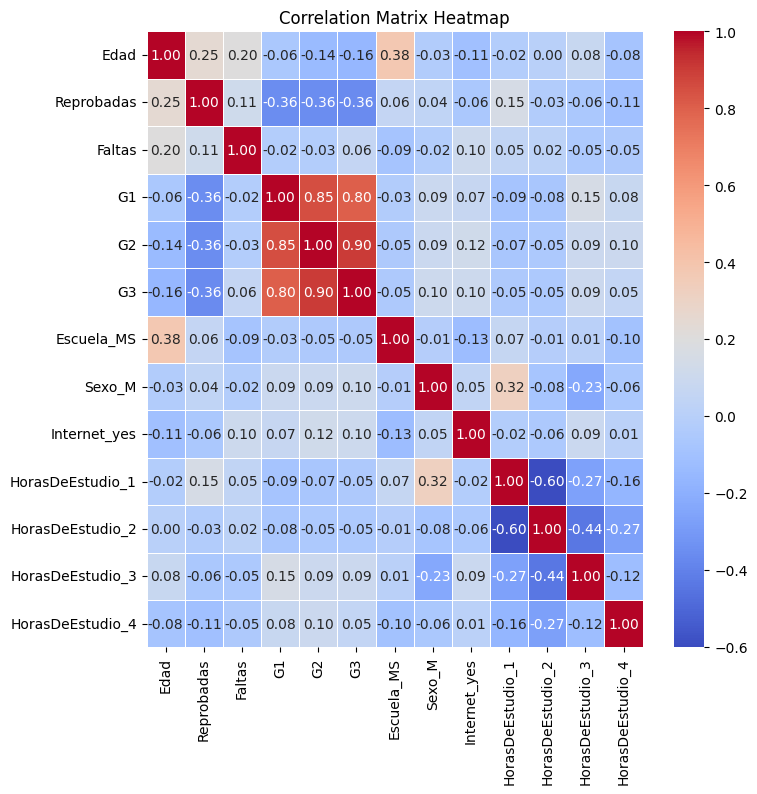

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",fmt=".2f",linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

Observando el **Heatmap** se pueden observar **algunas correlaciones fuertes**, sin embargo, esto no necesariamente significa que se deban de eliminar variables. Por ejemplo, existe una muy fuerte correlación entre las variables G1, G2 y G3. Aún así, **considerando que la variable de salida para un modelo de predicción con este data frame sería G3** y, por lo tanto, G1 y G2 son por lo tanto muy útiles para predecir G3, se deben de **conservar las 3 variables ya que son relevantes para el modelo**.

Otra correlación que es relativamente fuerte es entre las variables **HorasDeEstudio_1** y **HorasDeEstudio_2** y entre **HorasDeEstudio_2** y **HorasDeEstudio_3**. En este caso, las variables representan rangos de **menos de 2 horas**, **2-5 horas**, **5-10 horas** o **más de 10 horas**, por lo tanto, para reducir el número de variables y **evitar problemas de colinealidad**, se **mezclarán estas variables en dos** que serán **HorasDeEstudioBajo** y **HorasDeEstudioAlto** que tendrán un valor booleano y de esta manera se mantendrá solo una (**HorasDeEstudioAlto**) en el data frame.

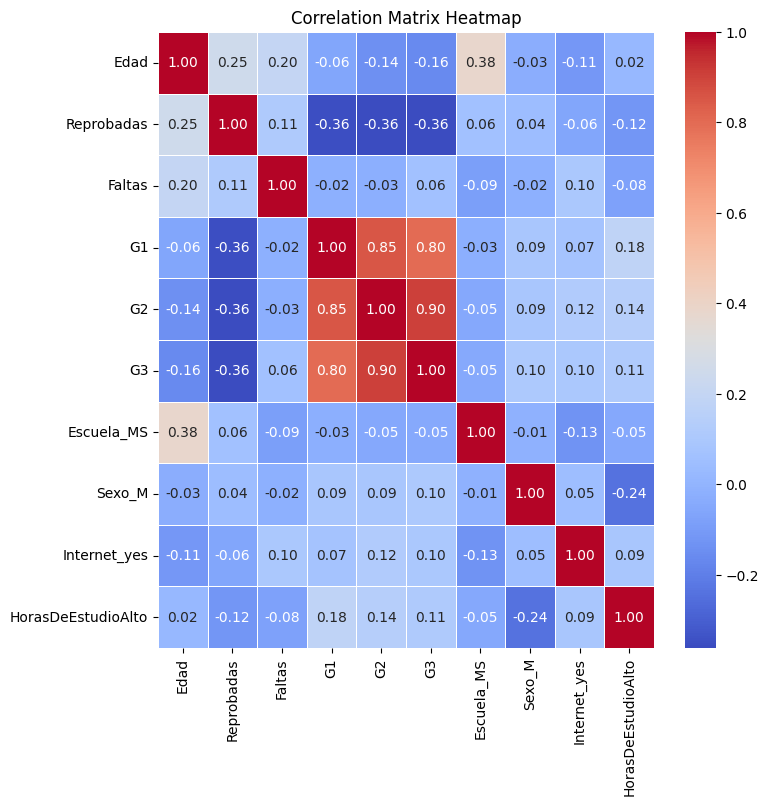

In [251]:
df = df.drop(columns=['HorasDeEstudio_1','HorasDeEstudio_2'])
df['HorasDeEstudioAlto'] = df[['HorasDeEstudio_3','HorasDeEstudio_4']].max(axis=1)
df = df.drop(columns=['HorasDeEstudio_3','HorasDeEstudio_4'])
corr_matrix = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm",fmt=".2f",linewidths=0.5)

plt.title("Correlation Matrix Heatmap")
plt.show()

**5.** Se incluyen **dos términos de interacción** para los pares de variables **G1-G2** y **Faltas-Edad**. Estos fueron elegidos ya que me llamó la atención observar las interacciones entre **dos periodos de calificaciones** y **la edad con el número de veces que faltan**. Esto se hace **multiplicando los valores de las variables** e incluyendo este nuevo término. Se imprimen un resumen de 5 líneas para observar los cambios.

In [252]:
df['G1:G2'] = df['G1'] * df['G2']
df['Faltas:Edad'] = df['Faltas'] * df['Edad']
print(df.head(5))

   Edad  Reprobadas  Faltas  G1  G2  G3  Escuela_MS  Sexo_M  Internet_yes  \
0    18           0       6   5   6   6       False   False         False   
1    17           0       4   5   5   6       False   False          True   
2    15           3      10   7   8  10       False   False          True   
3    15           0       2  15  14  15       False   False          True   
4    16           0       4   6  10  10       False   False         False   

   HorasDeEstudioAlto  G1:G2  Faltas:Edad  
0               False     30          108  
1               False     25           68  
2               False     56          150  
3                True    210           30  
4               False     60           64  


**6.** Por último, se entrena un **modelo de regresión lineal múltiple**. Se importan las funciones `train_test_split`, `LinearRegression`, `mean_squared_error` y `r2_score` de la librería **sklearn**. Con `train_test_split` se divide el dataframe en **80% de datos para entrenar** y **20% de datos para probar**. Se **entrena el modelo** con la función `LinearRegression` y se **calcula el MSE y R^2** con las funciones `mean_squared_error` y `r2_score`.

Después, con la función `predict()` se **hacen predicciones** con los datos de prueba y se **grafican con respecto a los datos reales de G3** en una gráfica de dispersión para posteriormente con todos estos datos, **analizar el desempeño del modelo**.

MSE: 1.9328833734199504
R^2: 0.8617787069056775


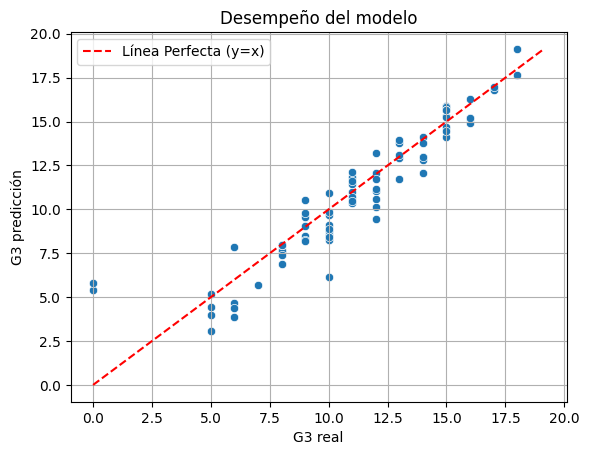

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

y = df['G3']
x = df.drop(columns=['G3'])
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

model = LinearRegression()
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:",mse)
print("R^2:",r2)

sns.scatterplot(x=y_test, y=y_pred)
min_val = min(min(y_test),min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val],color = 'red',linestyle='--', label="Línea Perfecta (y=x)")
plt.xlabel("G3 real")
plt.ylabel("G3 predicción")
plt.title("Desempeño del modelo")
plt.grid(True)
plt.legend()
plt.show()

**Conclusiones**

Observando los valores del **Mean Squared Error (MSE)** y la **R^2**, así como la gráfica de dispersión sobre los resultados del modelo, se puede concluir que **el modelo tiene un buen ajuste**. Visualmente, se observa que las predicciones siguen la dirección de lo que sería la línea perfecta de ajuste con los valores reales. El error promedio es de **menos de 2 puntos** que tomando en cuenta los valores de máximo 20, se tiene un **error aproximado de menos del 10%**. Además, la** R^2 es  0.86** lo cual es significativamente cercano a 1. Con estos datos, se puede concluir que **el modelo tiene un buen desempeño** pero también algunas **áreas de oportunidad** en las que puede mejorar para obtener un mejor ajuste y menos error.

**Referencias**
- [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/320/student+performance)
- [Publicación de Base de Datos](http://www3.dsi.uminho.pt/pcortez/student.pdf)